# Optymalizacja ciągła
## Laboratorium 3: Metoda najszybszego spadku



In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.style.use("ggplot") # tak żeby wykresy były ładniejsze
%matplotlib inline


#### Wyrażenia lambda
Do specyfikacji podproblemów 1D do optymalizacji przydatna będzie znajomość wyrażeń lambda. Wyrażenia lambda pozwalają ci na szybkie stworzenie jednolijnikowej funkcji. Zamiast pisać
```
def funkcja(argument1, argument2):
    return coś
```
możesz napisać
```
funkcja = lambda argument1, argument2: coś
```
Na przykład

In [2]:
def funkcja1(x):
    return 2*x+1

funkcja2 = lambda x: 2*x+1
print(funkcja1(5))
print(funkcja2(5))

11
11


#### Gotowa funkcja do złotego podziału
Do optymalizacji funkcji jednowymiarowych możesz użyć gotowej implementacji metody złotego podziału:

In [3]:
def golden_proportion_method(function, a=-10, b=10, epsilon=1e-8, max_steps=1000):
    alpha = (5 ** 0.5 - 1) / 2
    steps = 0
    xl = alpha * a + (1 - alpha) * b
    xr = (1 - alpha) * a + alpha * b
    fxl = function(xl)
    fxr = function(xr)

    while b - a > epsilon:
        m = (b + a) / 2
        if fxl < fxr:
            b = xr
            xr = xl
            fxr = fxl
            xl = alpha * a + (1 - alpha) * b
            fxl = function(xl)
        else:
            a = xl
            xl = xr
            fxl = fxr
            xr = (1 - alpha) * a + alpha * b
            fxr = function(xr)
        steps += 1
        if steps >= max_steps:
            break
    return (a + b) / 2

Aby ją wykonać na funkcji $(x-2)^2$ wykorzystamy wyrażenie lambda:

In [4]:
f = lambda x: (x-2)**2
golden_proportion_method(f, -10, 10)

1.9999999976356746

Znajdź minimum funkcji sinus (`np.sin`) w przedziale [0,1]

In [5]:
f_sin = lambda x: np.sin(x)
golden_proportion_method(f_sin, 0, 1)

3.5355097120310263e-09

Dodatkowo zostały dla Ciebie zaimplementowane funkcji `plot_gd_1d` i `plot_gd_2d` służące do rysowania funkcji, odpowiednio 1d i 2d. Pierwszym argumentem jest funkcja (np. wyrażenie lambda), a drugim *lista* punktów do narysowania (odwiedzonych przez algorytm). Funkcja wizualizuje 1) wartość f(x) w czasie oraz 2) wykres f(x) dla kolejnych wartości x wraz ze strzałkami pokazującymi kolejne kroki.

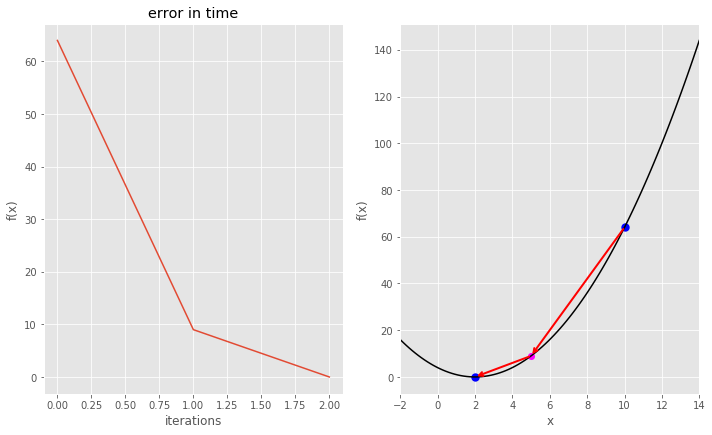

In [6]:
from helpers import plot_gd_1d,  plot_gd_2d, plot_gd_2d_nonvec
f = lambda x: (x-2)**2
plot_gd_1d(f, [10,5,2])

## Zadanie 1

Zaimplementuj metodę Gaussa-Seidela dla funkcji dwuwymiarowych. Przy problemach 1D możesz założyć zakres poszukiwań $[-10,10]$.

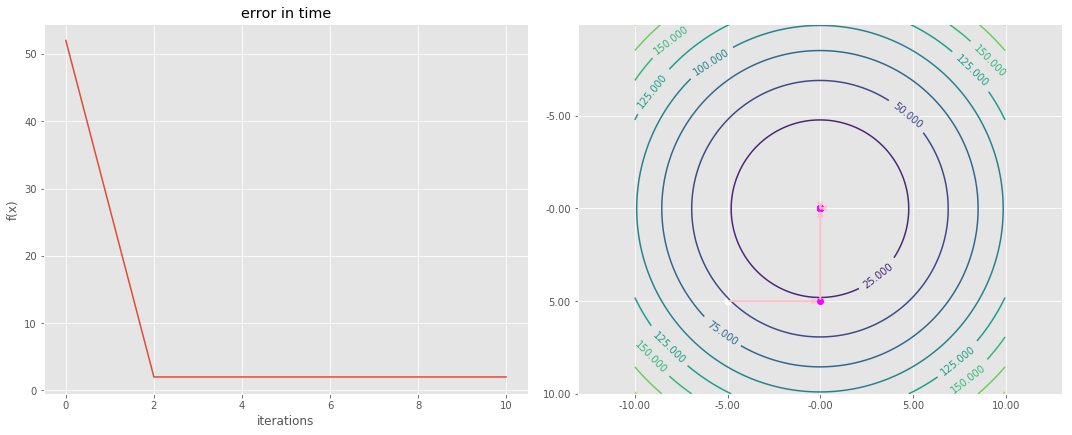

In [8]:
def run_gs(f, initial_x, initial_y):
    """
    Algorytm Gaussa-Seidela dla funkcji 2 wymiarowych
    Wejście: 
       f (x,y)- funkcja do optymalizacji
       initial_x, initial_y - koordynaty punktu startowego
    Wyjście: minimum funkcji f
    """
    x_in_time = [np.array([initial_x,initial_y])] #historia odwiedzonych punktów
    x, y = initial_x, initial_y #przepisanie startowych koordynat do x,y
    for i in range(10):
        if i%2 == 0:
            g = lambda alfa: f(x + alfa, y)
            x = x + golden_proportion_method(g, -10, 10)
        else:
            g = lambda alfa: f(x, y + alfa)
            y = y + golden_proportion_method(g, -10, 10)
        x_in_time.append(np.array([x,y]))

    #rysuj wynik
    plot_gd_2d_nonvec(f, x_in_time, contours=True)
    
f = lambda x,y: x**2+y**2 +2
run_gs(f, initial_x = -5, initial_y = 5)

Przetestuj działanie tej metody z kilkoma różnymi funkcjami optymalizacyjnymi. Spróbuj określić dla jakich funkcji ta metoda działa dobrze, a dla jakich funkcji nie.

## Zadanie 2
Zaimplementuj metodę Gaussa-Seidela dla funkcji o *dowolnej* wymiarowości. W tym celu punkt startowy funkcji $x$ jest reprezentowany jako numpy'owy wektor. Przy problemach 1D możesz założyć zakres poszukiwań $[-10,10]$.

*Wskazówka*: `np.eye(1,D,j)[0]` tworzy wektor zer o D elementach z jedynką na j-tej pozycji

In [9]:
np.eye(1,10,5)[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

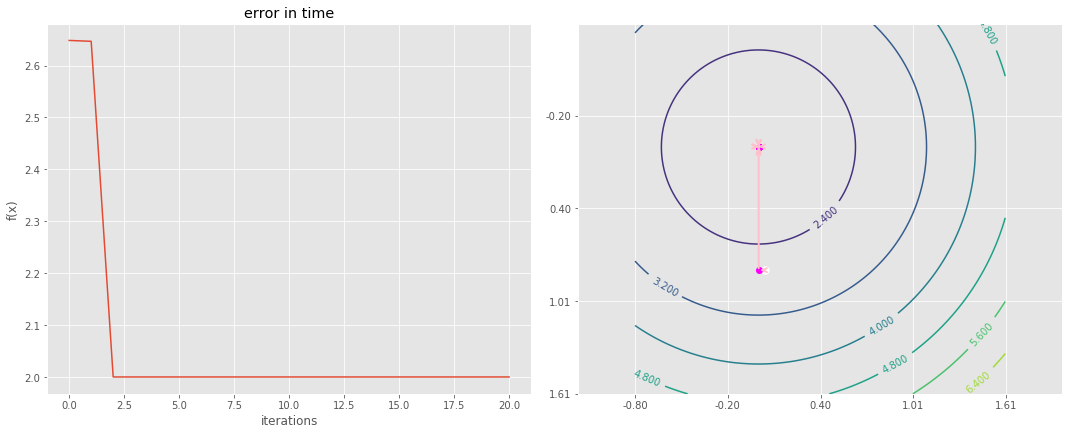

In [19]:
def run_gs(f, initial_x):
    """
    Algorytm Gaussa-Seidela dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       initial_x - >wektor< koordynat punktu startowego
    Wyjście: minimum funkcji f
    """
    x_in_time = [initial_x] #historia odwiedzonych punktów
    x = np.copy(initial_x) #przepisanie początkowego wektora koordynat do x
    D = initial_x.shape[0] #liczba wymiarów problemu
    for i in range(10):
        for j in range(D):
            g = lambda alfa: f(x + alfa * np.eye(1,D,j)[0])
            x = x + golden_proportion_method(g, -10, 10) * np.eye(1,D,j)[0]
            x_in_time.append(np.copy(x))
        

    #rysuj wynik
    plot_gd_2d(f, x_in_time, contours=True)

f = lambda x: sum(x ** 2 ) +2
run_gs(f, initial_x = np.random.rand(2))

Przetestuj działanie tej metody z kilkoma różnymi funkcjami optymalizacyjnymi. Spróbuj określić dla jakich funkcji ta metoda działa dobrze, a dla jakich funkcji nie.

## Zadanie 3
Zaimplementuj algorytm najszybszego spadku wzdłuż gradientu.

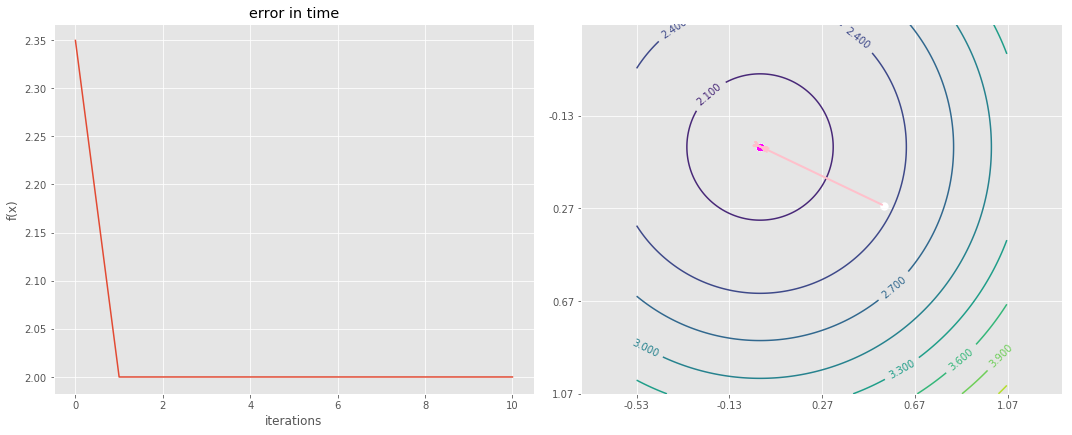

In [22]:
def run_cauchy(f, gradient, initial_x):
    """
    Algorytm Cauchy'iego dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       gradient (vector_x)- gradient funkcji do optymalizacji
       initial_x - >wektor< koordynat punktu startowego
    Wyjście: minimum funkcji f
    """
    x_in_time = [initial_x] #historia odwiedzonych punktów
    x = np.copy(initial_x) #przepisanie początkowego wektora koordynat do x
    D = initial_x.shape[0] #liczba wymiarów problemu
    for i in range(10):
        grad = gradient(x)
        g = lambda alfa: f(x - alfa * grad)
        x = x - golden_proportion_method(g, 0, 10) * grad
        x_in_time.append(np.copy(x))

    #rysuj wynik
    if D == 2:
        plot_gd_2d(f, x_in_time, contours=True)
    else:
        plot_gd_1d(f, x_in_time)
    
f = lambda x: sum(x ** 2 ) +2
gradient = lambda x: 2 * x

run_cauchy(f, gradient, initial_x = np.random.rand(2))

Przetestuj działanie tej metody z kilkoma różnymi funkcjami optymalizacyjnymi. Spróbuj określić dla jakich funkcji ta metoda działa dobrze, a dla jakich funkcji nie.

## Zadanie 4
Zaimplementuj metodę spadku wzdłuż gradientu.

In [ ]:
def run_gd(f, gradient, alpha, initial_x):
    """
    Algorytm Cauchy'iego dla funkcji n wymiarowych
    Wejście: 
       f (vector_x)- funkcja do optymalizacji
       gradient (vector_x)- gradient funkcji do optymalizacji
       alpha - długość kroku
       initial_x - >wektor< koordynat punktu startowego
    Wyjście: minimum funkcji f
    """
    x_in_time = [initial_x] #historia odwiedzonych punktów
    x = np.copy(initial_x) #przepisanie początkowego wektora koordynat do x
    D = initial_x.shape[0] #liczba wymiarów problemu
    for i in range(10):
        # TWÓJ KOD TUTAJ 
        # Po każdej aktualizacji x dodaj linijkę 
        #     x_in_time.append(np.copy(x))
        # aby uzwględnić zmianę na rysunku

    #rysuj wynik
    if D == 2:
        plot_gd_2d(f, x_in_time, contours=True)
    else:
        plot_gd_1d(f, x_in_time)

        
f = lambda x: sum(x ** 2 ) +2
gradient = lambda x: 2 * x
run_gd(f, gradient, 0.5, initial_x = np.random.rand(2))

Zainicjalizuj punkt startowy losowo oraz przetestuj algorytm dla różnych wartości długości kroku dla funkcji jednowymiarowych.

Sugerowane wartości długości kroku:
* 1.5
* 1
* 0.99
* 0.5
* 0.01


In [ ]:
# Funkcja do minimalizacji
f = lambda x: x ** 2 + 5 * x
# Gradient z tej funkcji (właściwie 1d więc pochodna...)
gradient = lambda x: 2 * x + 5

run_gd(f, gradient, alpha=0.1, initial_x = np.random.rand(1))
run_gd(f, gradient, alpha=0.5, initial_x = np.random.rand(1))
run_gd(f, gradient, alpha=1.4, initial_x = np.random.rand(1))

Powtórz ćwiczenie dla funkcji dwuwymiarowych. Sugerowane wartości długości kroku:
* 1.5
* 1
* 0.99
* 0.5
* 0.01


In [ ]:
a = np.float64([1,0.2])
f = lambda x: sum(a*x ** 2 )
gradient = lambda x: 2 * x*a

run_gd(f, gradient, 0.1, initial_x = np.random.rand(2))
run_gd(f, gradient, 0.5, initial_x = np.random.rand(2))
run_gd(f, gradient, 1.4, initial_x = np.random.rand(2))
